In [1]:
import sys
#print (sys.path)
sys.path.append('/Users/kefang/Softwares/analysis_001')

import os

import numpy as np

import healpy as hp

from scipy.optimize import minimize

import emcee

from KIPAC.nuXgal import Defaults

from KIPAC.nuXgal import file_utils

from KIPAC.nuXgal.EventGenerator import EventGenerator

from KIPAC.nuXgal.Likelihood import Likelihood

from KIPAC.nuXgal.file_utils import read_maps_from_fits, write_maps_to_fits

from KIPAC.nuXgal.hp_utils import vector_apply_mask, vector_apply_mask_hp

from KIPAC.nuXgal.plot_utils import FigureDict

from KIPAC.nuXgal.GalaxySample import GalaxySample

from KIPAC.nuXgal.WeightedAeff  import WeightedAeff

%matplotlib inline  

from KIPAC.nuXgal.NeutrinoSample  import NeutrinoSample
from scipy import stats

import matplotlib.pyplot as plt

from KIPAC.nuXgal.FermipyCastro import LnLFn


Using /Users/kefang/Softwares/analysis_001 for NUXGAL_DIR


In [2]:
file = np.loadtxt('/Users/kefang/Desktop/numu_HESE_track.txt')
countsmap = np.zeros((Defaults.NEbin, hp.pixelfunc.nside2npix(Defaults.NSIDE)))
_index_map_pixel = hp.pixelfunc.ang2pix(Defaults.NSIDE, theta=np.radians(90. - file[:, 0]) , phi=np.radians(file[:, 1]))

for i, _ in enumerate(file):
    countsmap[3][_index_map_pixel[i]] += 1.
    
ns = NeutrinoSample()
ns.inputCountsmap(countsmap)
print (ns.getEventCounts())

[ 0.  0.  0. 34.  0.  0.  0.]


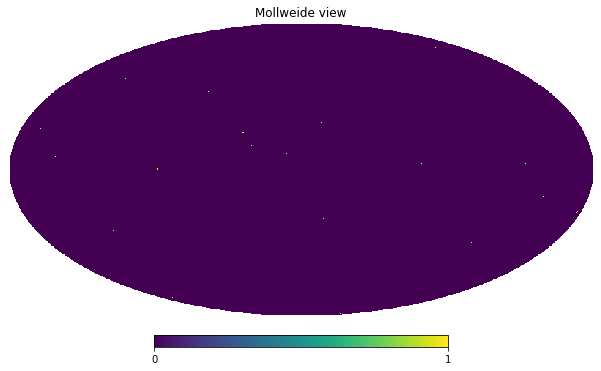

In [3]:
hp.mollview(ns.countsmap[3])


In [3]:
llh = Likelihood(N_yr=3,  galaxyName='WISE', computeSTD=False, Ebinmin=3, Ebinmax=4, lmin=50)
llh.inputData(ns)
print (llh.minimize__lnL())

(array([0.44279985]), 1.193459369335244)


In [11]:
ns2 = NeutrinoSample()
ns2.inputCountsmap(EventGenerator('IC86-2012', 'observed_numu_fraction').SyntheticData(0.03, 1., density_nu=GalaxySample('WISE').density))
llh.inputData(ns2)
print (ns2.getEventCounts())
print (llh.minimize__lnL())


[1103.0 956.0 375.0 397.0 3.0 0.0 0.0]
(array([0.77830473]), 50.4759653741325)


[0.00391027 0.04331592 0.45597574]


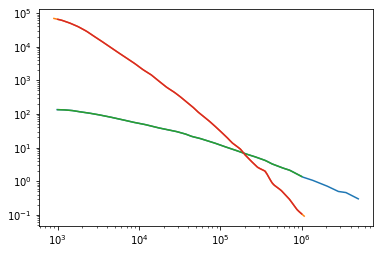

In [21]:
ratio_astro = np.loadtxt('/Users/kefang/Desktop/astro.txt')
ratio_atm = np.loadtxt('/Users/kefang/Desktop/atm.txt')
plt.plot(ratio_astro[:,0], ratio_astro[:,1])
plt.plot(ratio_atm[:,0], ratio_atm[:,1])
xE = np.logspace(3, 6, 100)
import scipy 

N_astro = scipy.interpolate.interp1d(np.log10(ratio_astro[:,0]), np.log10(ratio_astro[:,1]))
N_atm = scipy.interpolate.interp1d(np.log10(ratio_atm[:,0]), np.log10(ratio_atm[:,1]))


plt.plot(xE, 10**N_astro(np.log10(xE)))

plt.plot(xE, 10**N_atm(np.log10(xE)))
plt.yscale('log')
plt.xscale('log')


ratio = np.zeros(3)
for i, logE_left in enumerate([3, 4, 5]):
    
    logE_i = np.linspace(0, 1, 20) + logE_left
    Nastro_i = np.sum( 10.** N_astro(logE_i) )
    Natm_i = np.sum(10. ** N_atm(logE_i))
    ratio[i] = float(Nastro_i) / (Nastro_i + Natm_i)
print (ratio)
    


[29294.0 24381.0 185.0 3.0 0.0 0.0 0.0]


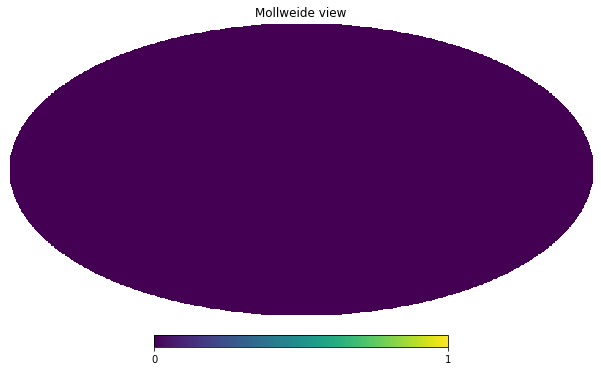

In [4]:
eg = EventGenerator('IC86-2011', 'observed_numu_fraction')
a = eg.SyntheticData(1., 1., density_nu=GalaxySample('WISE').density)
hp.mollview(a[3])
ns = NeutrinoSample()
ns.inputCountsmap(a)
ns.updateMask(Defaults.idx_muon)
print (ns.getEventCounts())

In [12]:
testfigpath = os.path.join(Defaults.NUXGAL_PLOT_DIR, 'Fig_')
countsmappath = os.path.join(Defaults.NUXGAL_DATA_DIR, 'IceCube3yr_countsmap{i}.fits')
IC3yr = NeutrinoSample()
IC3yr.inputData(countsmappath)
IC3yr.updateMask(Defaults.idx_muon)
print (IC3yr.getEventCounts())

[65549.0 90007.0 1791.0 34.0 0.0 0.0 0.0]


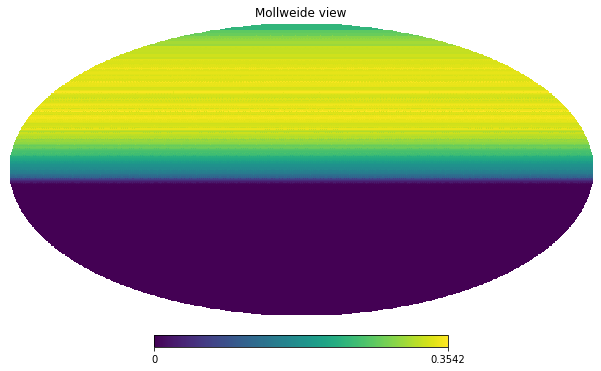

In [2]:
wa = WeightedAeff()
hp.mollview(wa.exposuremap[1])

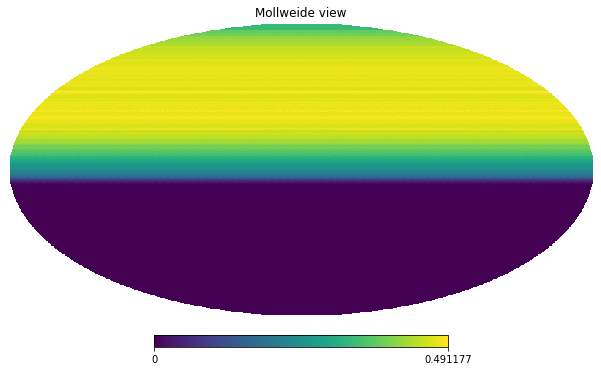

In [3]:
aeff_path = os.path.join('/Users/kefang/Desktop/old', 'WeightedAeff_' + wa.year + '_' + str(wa.spectralIndex) + '_' + '{i}.fits')

compare = file_utils.read_maps_from_fits(aeff_path, Defaults.NEbin)
hp.mollview(compare[1])

/Applications/miniconda3/envs/nuXgal/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Applications/miniconda3/envs/nuXgal/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


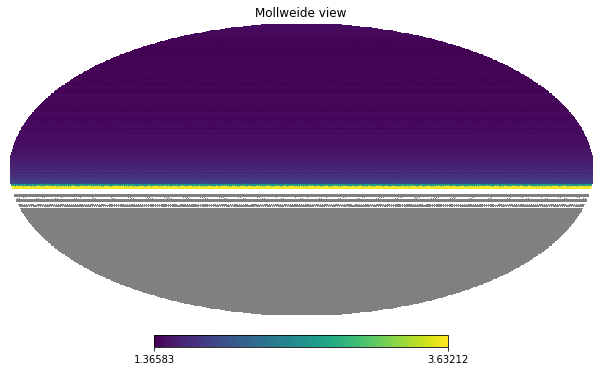

In [5]:
hp.mollview(wa.exposuremap[1] / compare[1] )

In [7]:
gs = GalaxySample('WISE')
overdensity = gs.galaxymap.copy()
overdensity[gs.idx_galaxymask] = hp.UNSEEN
overdensity = hp.ma(overdensity)
overdensity = overdensity / overdensity.mean() - 1.
f_sky = 1. - len(gs.idx_galaxymask[0]) / float(Defaults.NPIXEL)

print (f_sky)

0.8263346354166666


In [14]:
mask_nu = np.zeros(Defaults.NPIXEL, dtype=np.bool)
mask_nu[Defaults.idx_muon] = 1.
mask_nu[gs.idx_galaxymask] = 1.
idx_mask = np.where(mask_nu != 0)
f_sky2 = 1. - len(idx_mask[0]) / float(Defaults.NPIXEL)
print (f_sky2)

0.37558492024739587


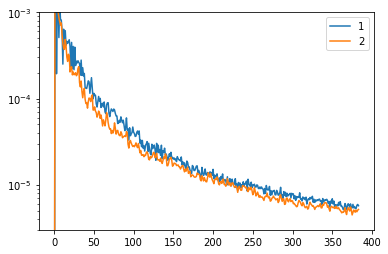

In [22]:
overdensity2 = gs.galaxymap.copy()
overdensity2[idx_mask] = hp.UNSEEN
overdensity2 = hp.ma(overdensity2)
overdensity2 = overdensity2 / overdensity2.mean() - 1.
plt.plot(Defaults.ell, hp.anafast(overdensity) / f_sky, label='1')

plt.plot(Defaults.ell, hp.anafast(overdensity2) / f_sky2, label='2')
#plt.plot(Defaults.ell, hp.sphtfunc.alm2cl(gs.overdensityalm) / f_sky, label='alm')
plt.legend()

plt.ylim(3e-6,1e-3)
plt.yscale('log')


In [23]:
WISE_data_dir = '/Users/kefang/work/neutrinoXgalaxy/data/WISE-2MASS galaxy sample/irsa_catalog_search_results.txt'

In [24]:
galaxySampleFile = np.loadtxt(WISE_data_dir)

In [28]:
index_map_pixel = hp.pixelfunc.ang2pix(512, np.radians(90. - galaxySampleFile[:, 1]), np.radians(galaxySampleFile[:, 0]))

galaxymap = np.zeros(hp.pixelfunc.nside2npix(512))

for i in index_map_pixel:
    galaxymap[i] += 1.


from astropy import units as u
from astropy.coordinates import SkyCoord
exposuremap_theta, exposuremap_phi = hp.pixelfunc.pix2ang(512, np.arange(12*512**2))

c_icrs = SkyCoord(ra= exposuremap_phi * u.radian, dec=(np.pi/2 - exposuremap_theta)*u.radian, frame='icrs')
idx_galaxymask = np.where(np.abs(c_icrs.galactic.b.degree) < 10)
galaxymap2 = galaxymap.copy()

In [29]:

galaxymap[idx_galaxymask] = hp.UNSEEN
galaxymap = hp.ma(galaxymap)
od = galaxymap / galaxymap.mean() - 1.
f_sky = 1. - len(gs.idx_galaxymask[0]) / float(Defaults.NPIXEL)

print (f_sky)

0.8263346354166666


0.3753032684326172


(0, 1000)

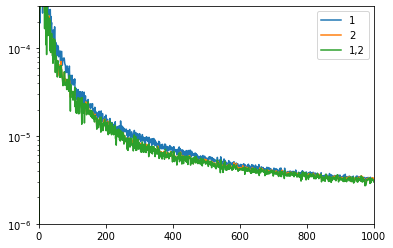

In [39]:

idx_muon = np.where(exposuremap_theta > np.radians(85.))
mask_nu = np.zeros(12*512**2, dtype=np.bool)
mask_nu[idx_muon] = 1.
mask_nu[idx_galaxymask] = 1.
idx_mask = np.where(mask_nu != 0)
f_sky2 = 1. - len(idx_mask[0]) / float(512**2 * 12)
print (f_sky2)
overdensity2 = galaxymap2 
overdensity2[idx_mask] = hp.UNSEEN
overdensity2 = hp.ma(overdensity2)
overdensity2 = overdensity2 / overdensity2.mean() - 1.


In [40]:
map = hp.alm2map(gs.overdensityalm, nside=128)
mask_nu = np.zeros(Defaults.NPIXEL, dtype=np.bool)
mask_nu[Defaults.idx_muon] = 1.
mask_nu[gs.idx_galaxymask] = 1.
idx_mask_128 = np.where(mask_nu != 0)
map[idx_mask_128] = hp.UNSEEN


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


(0, 500)

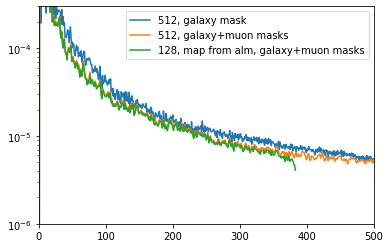

In [45]:
ell = range(3*512)
plt.plot(ell, hp.anafast(od) / f_sky, label='512, galaxy mask')
plt.plot(ell, hp.anafast(overdensity2) / f_sky2, label='512, galaxy+muon masks')
plt.plot(Defaults.ell, hp.anafast(map) / f_sky2, label='128, map from alm, galaxy+muon masks')

plt.legend()

plt.ylim(1e-6,3e-4)
plt.yscale('log')

plt.xlim(0,500)



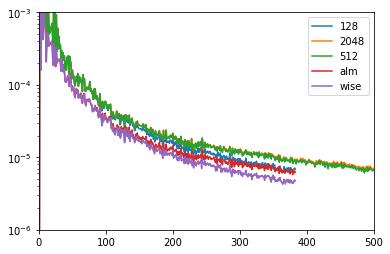

In [17]:


plt.plot(Defaults.ell, cl1, label='128')
plt.plot(np.arange(2048*3), cl2, label='2048')

plt.plot(np.arange(512*3), cl3, label='512')
plt.plot(np.arange(128 *3), cl_alm[0:Defaults.MAX_L+1], label='alm')
#plt.plot(Defaults.ell, GalaxySample('analy').analyCL[0:384] / 0.28, label='analy')

plt.plot(Defaults.ell, hp.anafast( GalaxySample('WISE').overdensity), label='wise')

plt.yscale('log')
plt.xlim(0, 500)
plt.ylim(1e-6, 1e-3)
plt.legend()

In [2]:
llh = Likelihood(N_yr=1,  galaxyName='WISE', computeSTD=False, N_re=300)
countsmappath = os.path.join(Defaults.NUXGAL_DATA_DIR, 'IceCube3yr_countsmap{i}.fits')
ns = NeutrinoSample()
ns.inputData(countsmappath)
ns.updateMask(llh.idx_mask)
w_data = ns.getCrossCorrelation(llh.gs.overdensity)
Ncount = ns.getEventCounts()
print (Ncount)
lmin = 50 

[54184.0 74851.0 1499.0 32.0 0.0 0.0 0.0]


In [8]:
eg = EventGenerator(year='IC86-2012', astroModel='hese')
Nastro = np.random.poisson(eg.Nastro_1yr_Aeffmax)
map = eg.astroEvent_galaxy(Nastro, GalaxySample('WISE').density)
print (map.sum(axis =1))

eg.initializeAstro('numu')
Nastro = np.random.poisson(eg.Nastro_1yr_Aeffmax)
map = eg.astroEvent_galaxy(Nastro, GalaxySample('WISE').density)
print (map.sum(axis =1))

map = eg.atmEvent(1)
print (map.sum(axis =1))




[ 44 352 110  10   4   0   0]
[ 1 36 56 14  6  2  0]
[39817 35740 15934 13633   211     0     0]


In [30]:
f_Ebin = np.linspace(0, 2, 1000)
lnL_Ebin = np.zeros_like(f_Ebin)
for i, f in enumerate(f_Ebin):
    lnL_Ebin[i] = llh.log_likelihood_Ebin(f, w_data, Ncount, lmin, Ebin=1)

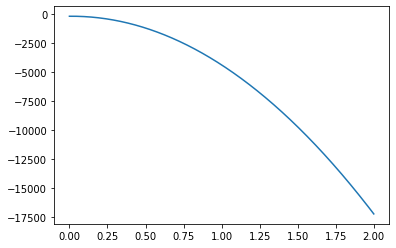

In [31]:
plt.plot(f_Ebin, lnL_Ebin)

In [32]:
castro = LnLFn(f_Ebin, -lnL_Ebin)

In [33]:
print (castro.mle(), castro.TS())
print (castro.getLimit(0.05))
print (castro.getInterval(0.32))
print (llh.minimize__lnL(w_data, Ncount, lmin, 1, 4))

0.0160160159676154 [1.94751554]
0.03266647890877514
(0.0043176518273044685, 0.025708819094440484)
(array([0.01501694, 0.        , 0.33870418]), 2.3816031798035056)


In [2]:
eg = EventGenerator()
gs = GalaxySample('WISE')

6.180124696859705e-06


(1e-06, 0.0001)

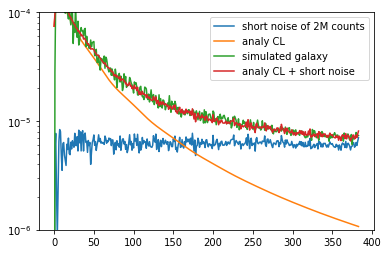

In [24]:
N = 2e6
map = np.random.poisson(N / Defaults.NPIXEL, Defaults.NPIXEL)
map_od = map / np.mean(map) - 1. 
plt.plot(np.arange(3*Defaults.NSIDE), hp.anafast(map_od), label='short noise of 2M counts')
print ( np.mean(hp.anafast(map_od))  ) 
plt.plot(Defaults.ell, GalaxySample('analy').analyCL[0:3*Defaults.NSIDE], label='analy CL')
plt.plot(Defaults.ell, hp.anafast(GalaxySample('analy').overdensity), label='simulated galaxy')
plt.plot(Defaults.ell, GalaxySample('analy').analyCL[0:3*Defaults.NSIDE] +hp.anafast(map_od), label='analy CL + short noise' )
plt.yscale('log')
plt.legend()
plt.ylim(1e-6, 1e-4)

In [36]:
counts_astro = eg.astroEvent_galaxy(eg.Nastro_1yr_Aeffmax * 10000, gs.density)
print (eg.Nastro_1yr_Aeffmax * 10000)
ns = NeutrinoSample()
ns.inputCountsmap(counts_astro, 2.28)
w_cross_flux = ns.getCrossCorrelation(gs.overdensity)
overdensity_counts = ns.countsmap[1] / np.mean(ns.countsmap[1]) - 1
w_cross_counts = hp.anafast(gs.overdensity, overdensity_counts)

[ 35809.8102794  645511.42871213 918433.7923724  431562.65759444
 113666.94128499  23709.53421309   3450.67137184]


(3e-06, 0.0003)

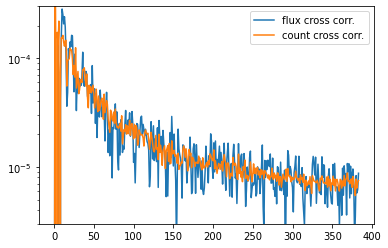

In [35]:
plt.plot(Defaults.ell, w_cross_flux[1], label='flux cross corr.')

plt.plot(Defaults.ell, w_cross_counts, label='count cross corr.')

#plt.plot(Defaults.ell, gs.analyCL[0:384], label='analyCL')
#plt.plot(Defaults.ell, hp.anafast(gs.overdensity), label='galaxy auto corr.')
plt.yscale('log')
plt.legend()
plt.ylim(3e-6, 3e-4)

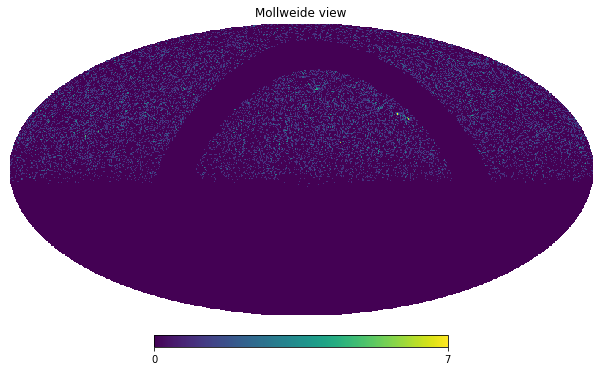

In [3]:
counts_astro = eg.astroEvent_galaxy(eg.Nastro_1yr_Aeffmax * 1000, gs.density)
hp.mollview(counts_astro[1])



(1e-06, 10.0)

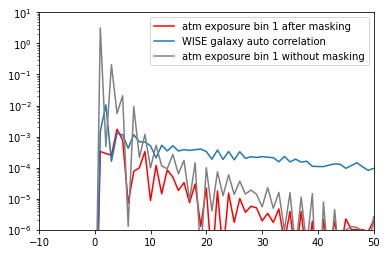

In [10]:
wa = WeightedAeff()
map = wa.exposuremap_atm[1].copy()
map[Defaults.idx_muon] = hp.UNSEEN
map = hp.ma(map)
map_overdensity = map / map.mean() - 1.
plt.plot(Defaults.ell, hp.anafast(map_overdensity),color='r', label='atm exposure bin 1 after masking')
plt.plot(Defaults.ell, hp.anafast(gs.overdensity), label='WISE galaxy auto correlation')


wa_overdensity = wa.exposuremap_atm[1] / np.mean(wa.exposuremap_atm[1]) - 1
plt.plot(Defaults.ell, hp.anafast(wa_overdensity),color='grey', label='atm exposure bin 1 without masking')
#wa_overdensity = wa.exposuremap_atm[2] / np.mean(wa.exposuremap_atm[2]) - 1
#plt.plot(Defaults.ell, hp.anafast(wa_overdensity), label='atm exposure bin 2')
#wa_overdensity_astro = wa.exposuremap_astro[1] / np.mean(wa.exposuremap_astro[1]) - 1
#plt.plot(Defaults.ell, hp.anafast(wa_overdensity_astro), label='astro exposure bin 1')
#plt.plot(Defaults.ell, gs.analyCL[0:384], label='analyCL')

plt.xlim(-10, 50)
plt.yscale('log')
plt.legend()
plt.ylim(1e-6, 1e1)


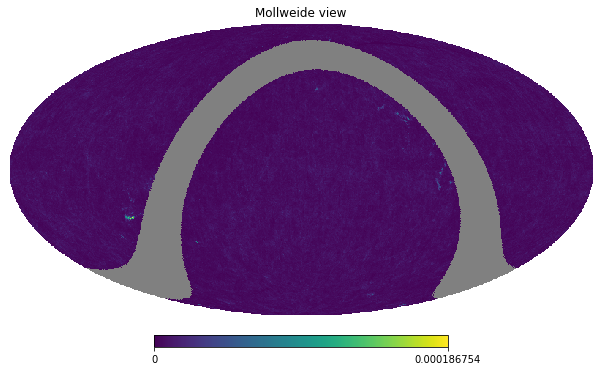

In [6]:
hp.mollview(gs.density)

In [2]:
ns = NeutrinoSample()
cf = Analyze()

0 0 10 100.0 794.3 100.0 1000.0 6.390783742928451e-06
1 10 20 1000.0 7943.0 1000.0 10000.0 1.2751289965380898e-08
2 20 30 10000.0 79430.0 10000.0 100000.0 2.5442168335165318e-11
3 30 40 100000.0 794300.0 100000.0 1000000.0 5.076379969024986e-14
4 40 50 1000000.0 7943000.0 1000000.0 10000000.0 1.0128709648658439e-16
5 50 60 10000000.0 79430000.0 10000000.0 100000000.0 2.0209432661229856e-19
6 60 70 100000000.0 794300000.0 100000000.0 1000000000.0 4.032311939585315e-22
0 0 10 100.0 794.3 100.0 1000.0 0.013498927135788865
1 10 20 1000.0 7943.0 1000.0 10000.0 0.0008517247218928959
2 20 30 10000.0 79430.0 10000.0 100000.0 5.374019687536725e-05
3 30 40 100000.0 794300.0 100000.0 1000000.0 3.390777191232449e-06
4 40 50 1000000.0 7943000.0 1000000.0 10000000.0 2.139435772304033e-07
5 50 60 10000000.0 79430000.0 10000000.0 100000000.0 1.3498927135788842e-08
6 60 70 100000000.0 794300000.0 100000000.0 1000000000.0 8.517247218928942e-10


/Users/kefang/Softwares/analysis_001/KIPAC/nuXgal/NeutrinoSample.py:48: RuntimeWarning: divide by zero encountered in true_divide
  weightedAeff[i] += np.power(self.Ec_eff[j], 1 - spectralIndex) / self.Aeff_table[j * 200 + self.index_coszenith]


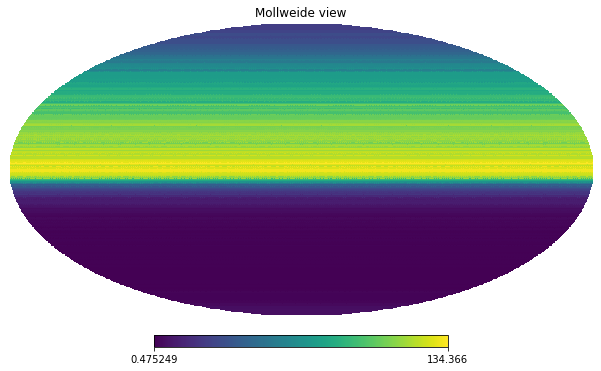

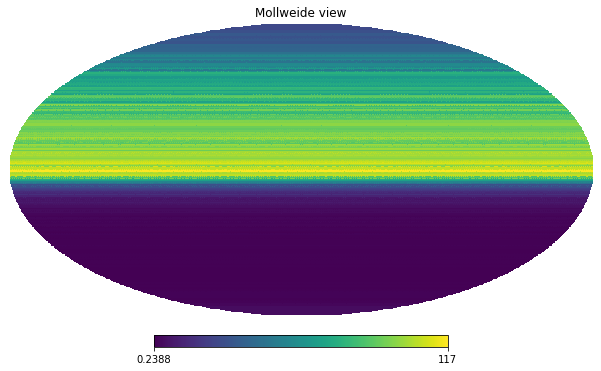

In [9]:
#map = ns.weightedAeff(6)
#hp.mollview(map[3])


hp.mollview(ns.exposuremap_atm[3])
hp.mollview(ns.Aeff_table[30 * 200 + ns.index_coszenith])


0 0 10 100.0 794.3 100.0 1000.0 5.635856915108199
1 10 20 1000.0 7943.0 1000.0 10000.0 4.4767202745365315
2 20 30 10000.0 79430.0 10000.0 100000.0 3.555985313027002
3 30 40 100000.0 794300.0 100000.0 1000000.0 2.8246195364022104
4 40 50 1000000.0 7943000.0 1000000.0 10000000.0 2.243675050118084
5 50 60 10000000.0 79430000.0 10000000.0 100000000.0 1.7822144418552115
6 60 70 100000000.0 794300000.0 100000000.0 1000000000.0 1.4156632514989715


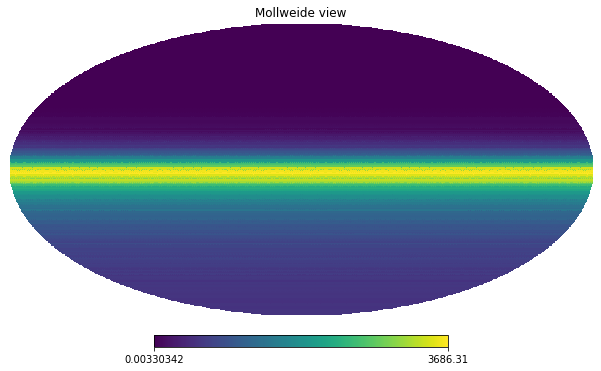

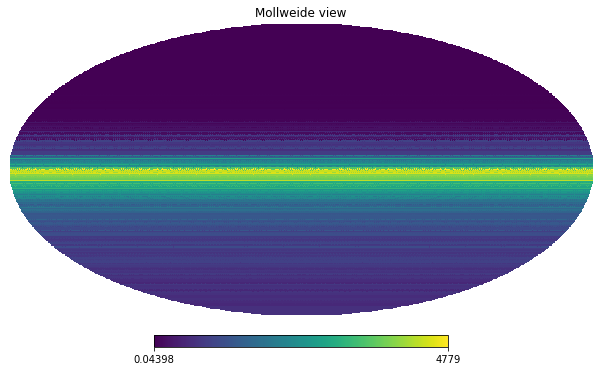

In [13]:
map = ns.weightedAeff(1.1)
#hp.mollview(ns.exposuremap_astro[3])
hp.mollview(map[5])
hp.mollview(cf.exposuremap[5])



In [14]:
map = ns.weightedAeff(1)

0 10 100.0 794.3 100.0 1000.0
10 20 1000.0 7943.0 1000.0 10000.0
20 30 10000.0 79430.0 10000.0 100000.0
30 40 100000.0 794300.0 100000.0 1000000.0
40 50 1000000.0 7943000.0 1000000.0 10000000.0
50 60 10000000.0 79430000.0 10000000.0 100000000.0
60 70 100000000.0 794300000.0 100000000.0 1000000000.0


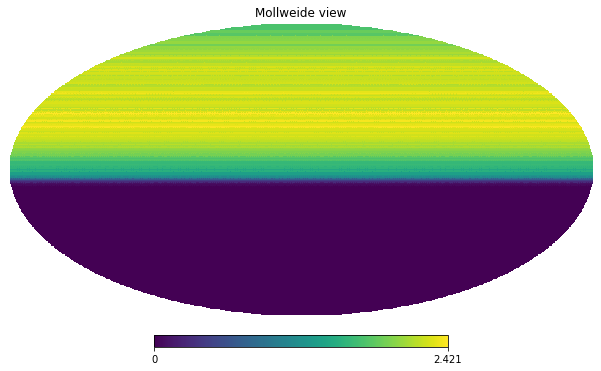

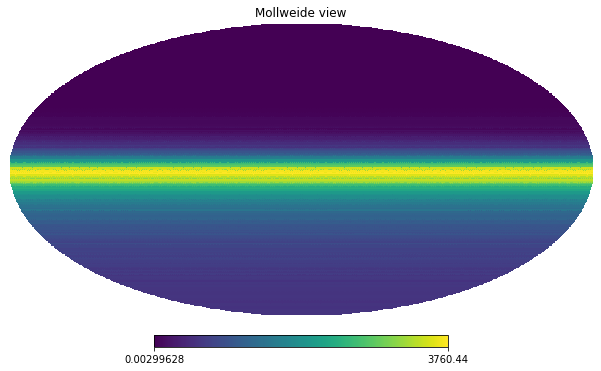

In [25]:
hp.mollview(map[5])

In [2]:
N_yr = 3
galaxyName = 'WISE'
llh = Likelihood(N_yr=N_yr,  galaxyName=galaxyName, computeSTD=False, N_re=100)



0.09999977626883176

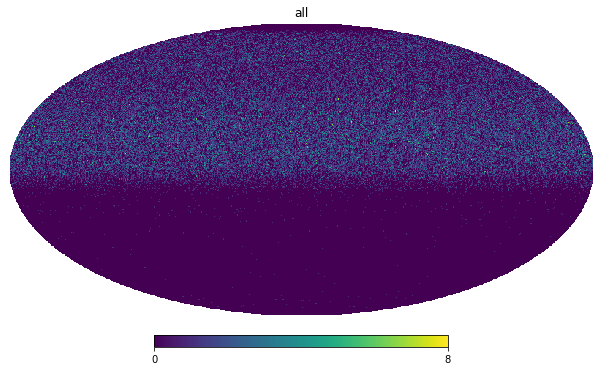

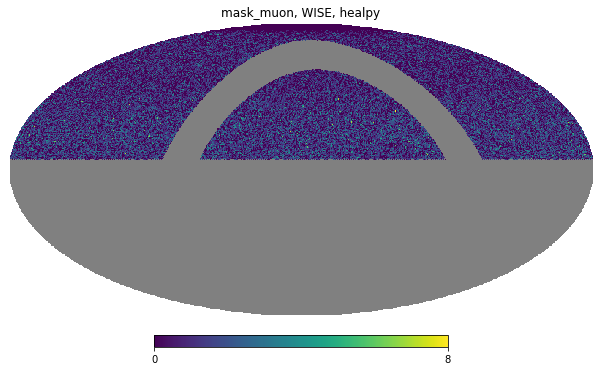

In [36]:
datamap = llh.eg.SyntheticData(N_yr, f_diff=0., density_nu=llh.gs.density)
hp.mollview(datamap[0], title="all")


#datamap = vector_apply_mask(datamap, llh.idx_mask, copy=False)
#hp.mollview(datamap[0], title="mask_muon, WISE")


dm = datamap[0] * 1.0
dm[llh.idx_mask] = hp.UNSEEN
hp.mollview(dm, title="mask_muon, WISE, healpy")



(1e-06, 0.001)

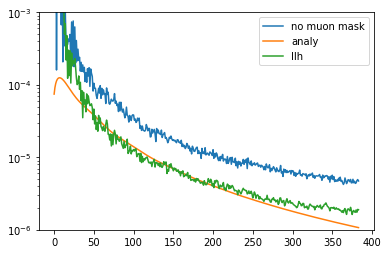

In [5]:
hpMask = hp.pixelfunc.ma(np.ones(Defaults.NPIXEL))
hpMask.mask = llh.gs.mask
plt.plot(np.arange(Defaults.NCL), hp.anafast( llh.gs.overdensity + hpMask),label='no muon mask')

plt.yscale('log')
analyCLpath = os.path.join(Defaults.NUXGAL_ANCIL_DIR, 'Cl_ggRM.dat')
analyCL = np.loadtxt(analyCLpath)
plt.plot(np.arange(Defaults.NCL), analyCL[0:Defaults.NCL], label='analy')
plt.plot(np.arange(Defaults.NCL), llh.w_model_f1[0], label='llh')
#plt.plot(np.arange(Defaults.NCL), llh.w_atm_std[0], label='std')

#plt.plot(np.arange(Defaults.NCL), llh.cf.crossCorrelationFromCountsmap_mask( datamap, llh.gs.overdensity, llh.hpMask )[0], label='mean')

#plt.plot(np.arange(Defaults.NCL), llh.cf.crossCorrelationFromCountsmap( datamap, llh.gs.overdensity )[0], label='mean')



#plt.plot(np.arange(Defaults.NCL), llh.w_atm_mean[1], label='mean')

plt.legend()
plt.ylim(1e-6, 1e-3)

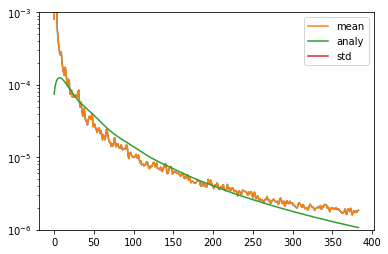

In [41]:
map = llh.gs.overdensity
#map[llh.gs.idx_galaxymask] = hp.UNSEEN

map[llh.idx_mask] = hp.UNSEEN


#hp.mollview(map)
plt.plot(np.arange(Defaults.NCL), hp.anafast(map) )

plt.plot(np.arange(Defaults.NCL), llh.w_model_f1[0], label='mean')
plt.yscale('log')
plt.ylim(1e-6, 1e-3)
analyCLpath = os.path.join(Defaults.NUXGAL_ANCIL_DIR, 'Cl_ggRM.dat')
analyCL = np.loadtxt(analyCLpath)
plt.plot(np.arange(Defaults.NCL), analyCL[0:Defaults.NCL] , label='analy')

plt.plot(np.arange(Defaults.NCL), llh.w_atm_std[0], label='std')


plt.legend()